In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.losses import MeanSquaredLogarithmicError

# Download the dataset
data = pd.read_csv("dataset_30dB.csv", header=None)

In [5]:
column_Target = 5
features = data.drop(column_Target, axis=1)
target = data[column_Target]

normal_data = features.iloc[1:10000,:]
anomaly_data = features.iloc[10001:,:]

train_data = normal_data.iloc[:7000,:]
test_data = normal_data.iloc[7001:,:]

target = target[10001:]
y_true = [] 
for item in target:
    y_true.append(float(item))



scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data.copy())
test_data_scaled = scaler.transform(test_data.copy())


anomaly_data_scaled = scaler.transform(anomaly_data.copy())

In [72]:
class AutoEncoder(Model):
  
  def __init__(self, output_units, code_size = 3):
    super().__init__()
    self.encoder = Sequential([
      Dense(4, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')])
    
    self.decoder = Sequential([
      Dense(4, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=train_data_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(train_data_scaled, train_data_scaled, epochs=50,
    batch_size=256, validation_data=(test_data_scaled, test_data_scaled))

Epoch 1/50
28/28 [==============================] - 1s 10ms/step - loss: 0.0082 - mse: 0.0181 - val_loss: 0.0083 - val_mse: 0.0182
Epoch 2/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0081 - mse: 0.0180 - val_loss: 0.0082 - val_mse: 0.0181
Epoch 3/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0081 - mse: 0.0179 - val_loss: 0.0082 - val_mse: 0.0180
Epoch 4/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0080 - mse: 0.0178 - val_loss: 0.0081 - val_mse: 0.0179
Epoch 5/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0080 - mse: 0.0178 - val_loss: 0.0081 - val_mse: 0.0179
Epoch 6/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0080 - mse: 0.0177 - val_loss: 0.0081 - val_mse: 0.0179
Epoch 7/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0080 - mse: 0.0177 - val_loss: 0.0081 - val_mse: 0.0178
Epoch 8/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0080 - mse: 0.0

In [20]:
def calc_threshold(model, train_data_scaled):
  reconst = model.predict(train_data_scaled)
  
  reconst_errors = tf.keras.losses.msle(reconst, train_data_scaled)
  

  thr = np.mean(reconst_errors.numpy()) \
      + np.std(reconst_errors.numpy())
  return thr

def get_predictions(model, test_data_scaled, threshold):
  predicts = model.predict(test_data_scaled)
  

  errors = tf.keras.losses.msle(predicts, test_data_scaled)
  
  anomaly = pd.Series(errors) > threshold
  preds = anomaly.map(lambda x: 0.0 if x == True else 1.0)
  return preds

threshold = calc_threshold(model, train_data_scaled)

predictions = get_predictions(model, anomaly_data_scaled, threshold)

y_pred = []
for item in predictions:
    y_pred.append(float(item))


print("Accuracy score is: ", accuracy_score(y_true, y_pred)*100)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Accuracy score is:  98.0


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0091 - mse: 0.0201 - val_loss: 0.0085 - val_mse: 0.0187
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - mse: 0.0187 - val_loss: 0.0083 - val_mse: 0.0182
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - mse: 0.0181 - val_loss: 0.0082 - val_mse: 0.0180
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - mse: 0.0182 - val_loss: 0.0081 - val_mse: 0.0178
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080 - mse: 0.0175 - val_loss: 0.0079 - val_mse: 0.0175
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - mse: 0.0173 - val_loss: 0.0078 - val_mse: 0.0172
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - mse: 0.0172 - val_loss: 0.0077 - val_mse: 0.0169
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - mse: 0.0168 - val_loss: 0.0075 - val_mse: 0.0166
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - mse:

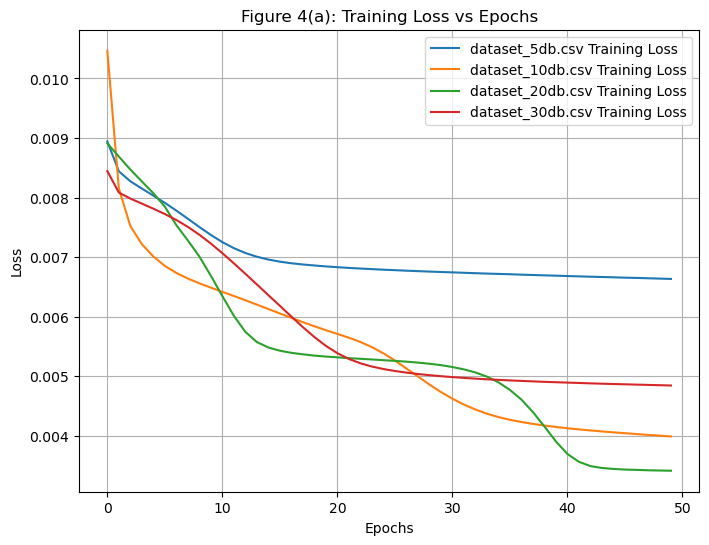

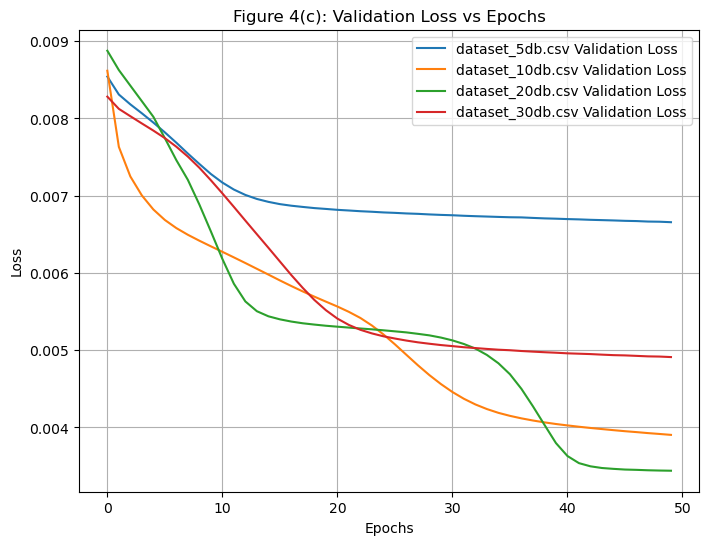

D:\anaconda\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


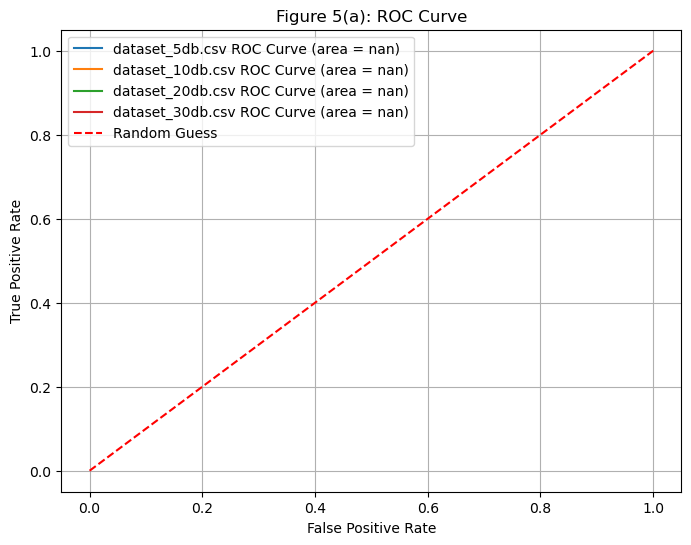

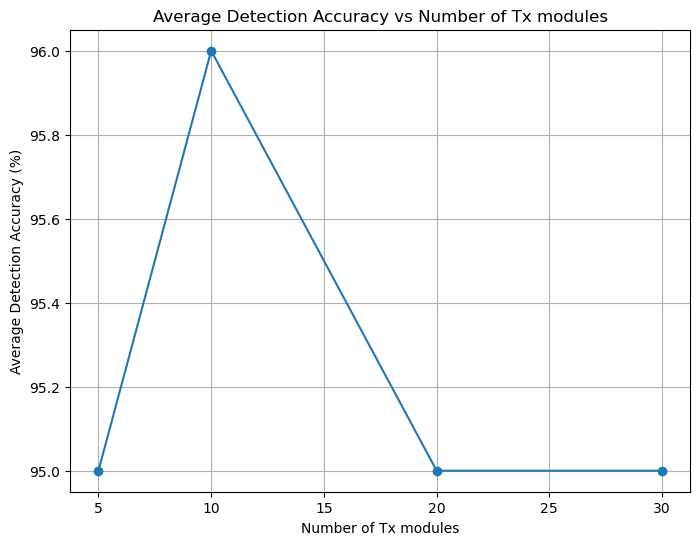

In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout

# List of datasets to process
datasets = ['dataset_5db.csv', 'dataset_10db.csv', 'dataset_20db.csv', 'dataset_30db.csv']

# Placeholder to store results
results = []

for dataset in datasets:
    # Load dataset
    data = pd.read_csv(dataset, header=None)
    
    column_Target = 5
    features = data.drop(column_Target, axis=1)
    target = data[column_Target]

    normal_data = features.iloc[1:10000,:]
    anomaly_data = features.iloc[10001:,:]

    train_data = normal_data.iloc[:7000,:]
    test_data = normal_data.iloc[7001:,:]

    target = target[10001:]
    y_true = [float(item) for item in target]

    # Scaling the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_data_scaled = scaler.fit_transform(train_data.copy())
    test_data_scaled = scaler.transform(test_data.copy())
    anomaly_data_scaled = scaler.transform(anomaly_data.copy())

    # Define the AutoEncoder model
    class AutoEncoder(Model):
        def __init__(self, output_units, code_size=3):
            super().__init__()
            self.encoder = Sequential([
                Dense(4, activation='relu'),
                Dropout(0.1),
                Dense(code_size, activation='relu')
            ])
            self.decoder = Sequential([
                Dense(4, activation='relu'),
                Dropout(0.1),
                Dense(output_units, activation='sigmoid')
            ])
        def call(self, inputs):
            encoded = self.encoder(inputs)
            decoded = self.decoder(encoded)
            return decoded

    # Create the model
    model = AutoEncoder(output_units=train_data_scaled.shape[1])
    
    # Compile the model
    model.compile(loss='msle', metrics=['mse'], optimizer='adam')
    
    # Train the model
    history = model.fit(train_data_scaled, train_data_scaled, epochs=50, batch_size=256, 
                        validation_data=(test_data_scaled, test_data_scaled))
    
    # Function to calculate the threshold
    def calc_threshold(model, train_data_scaled):
        reconst = model.predict(train_data_scaled)
        reconst_errors = tf.keras.losses.msle(reconst, train_data_scaled)
        thr = np.mean(reconst_errors.numpy()) + np.std(reconst_errors.numpy())
        return thr
    
    # Function to get predictions
    def get_predictions(model, test_data_scaled, threshold):
        predicts = model.predict(test_data_scaled)
        errors = tf.keras.losses.msle(predicts, test_data_scaled)
        anomaly = pd.Series(errors) > threshold
        preds = anomaly.map(lambda x: 0.0 if x == True else 1.0)
        return preds
    
    # Calculate threshold and predictions
    threshold = calc_threshold(model, train_data_scaled)
    predictions = get_predictions(model, anomaly_data_scaled, threshold)
    
    # Calculate accuracy
    y_pred = [float(item) for item in predictions]
    accuracy = accuracy_score(y_true, y_pred) * 100
    
    # Store results for plotting
    results.append({
        'dataset': dataset,
        'accuracy': accuracy,
        'history': history,
    })

# Now plot the graphs for accuracy

# Plot for Figure 4(a) - Loss vs Epochs for the training set
plt.figure(figsize=(8, 6))
for result in results:
    plt.plot(result['history'].history['loss'], label=f'{result["dataset"]} Training Loss')
plt.title('Figure 4(a): Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Figure 4(c) - Loss vs Epochs for the validation set
plt.figure(figsize=(8, 6))
for result in results:
    plt.plot(result['history'].history['val_loss'], label=f'{result["dataset"]} Validation Loss')
plt.title('Figure 4(c): Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Figure 5(a) - ROC Curve (True Positive Rate vs False Positive Rate)
plt.figure(figsize=(8, 6))
for result in results:
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{result["dataset"]} ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Guess')
plt.title('Figure 5(a): ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy vs number of Tx modules (which might be dataset based)
tx_modules = [5, 10, 20, 30]  # Assuming Tx modules correspond to the dataset names
accuracies = [result['accuracy'] for result in results]

plt.figure(figsize=(8, 6))
plt.plot(tx_modules, accuracies, marker='o')
plt.title('Average Detection Accuracy vs Number of Tx modules')
plt.xlabel('Number of Tx modules')
plt.ylabel('Average Detection Accuracy (%)')
plt.grid(True)
plt.show()


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0088 - mse: 0.0192 - val_loss: 0.0084 - val_mse: 0.0185
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - mse: 0.0185 - val_loss: 0.0084 - val_mse: 0.0184
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0084 - mse: 0.0183 - val_loss: 0.0084 - val_mse: 0.0184
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - mse: 0.0182 - val_loss: 0.0084 - val_mse: 0.0184
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084 - mse: 0.0184 - val_loss: 0.0084 - val_mse: 0.0184
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 - mse: 0.0184 - val_loss: 0.0084 - val_mse: 0.0184
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - mse: 0.0183 - val_loss: 0.0084 - val_mse: 0.0184
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 - mse: 0.0184 - val_loss: 0.0084 - val_mse: 0.0184
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - mse:

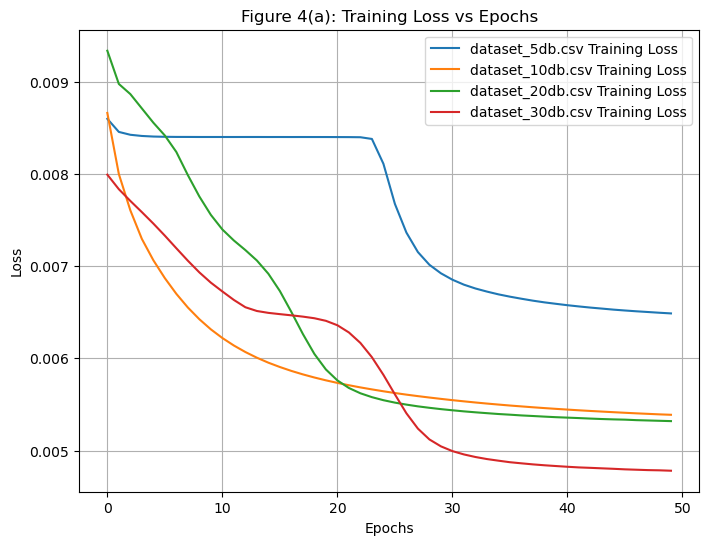

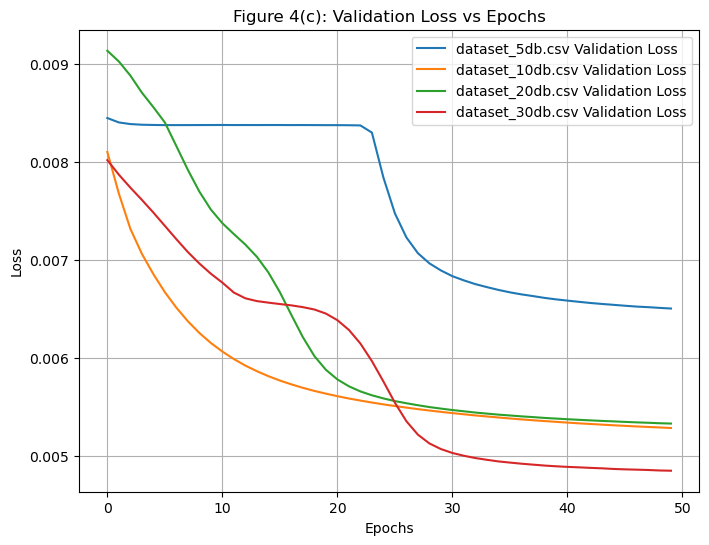

D:\anaconda\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
D:\anaconda\Lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


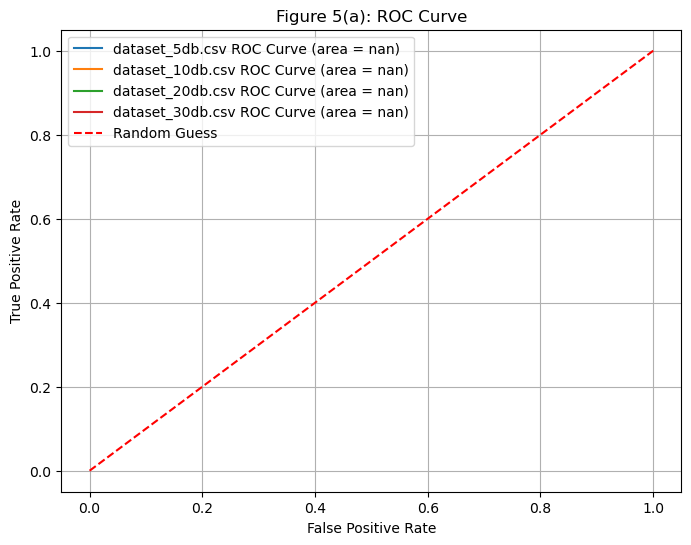

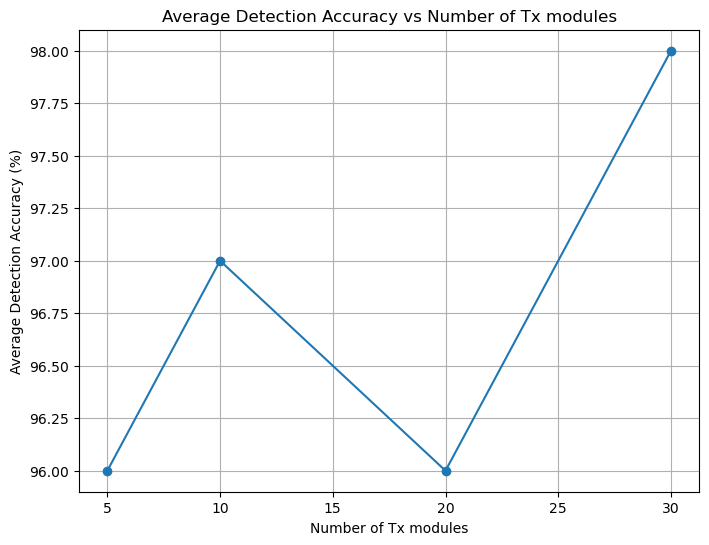

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout

# List of datasets to process
datasets = ['dataset_5db.csv', 'dataset_10db.csv', 'dataset_20db.csv', 'dataset_30db.csv']

# Placeholder to store results
results = []

for dataset in datasets:
    # Load dataset
    data = pd.read_csv(dataset, header=None)
    
    column_Target = 5
    features = data.drop(column_Target, axis=1)
    target = data[column_Target]

    normal_data = features.iloc[1:10000,:]
    anomaly_data = features.iloc[10001:,:]

    train_data = normal_data.iloc[:7000,:]
    test_data = normal_data.iloc[7001:,:]

    target = target[10001:]
    y_true = [float(item) for item in target]

    # Scaling the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_data_scaled = scaler.fit_transform(train_data.copy())
    test_data_scaled = scaler.transform(test_data.copy())
    anomaly_data_scaled = scaler.transform(anomaly_data.copy())

    # Define the AutoEncoder model
    class AutoEncoder(Model):
        def __init__(self, output_units, code_size=3):
            super().__init__()
            self.encoder = Sequential([
                Dense(4, activation='relu'),
                Dropout(0.1),
                Dense(code_size, activation='relu')
            ])
            self.decoder = Sequential([
                Dense(4, activation='relu'),
                Dropout(0.1),
                Dense(output_units, activation='sigmoid')
            ])
        def call(self, inputs):
            encoded = self.encoder(inputs)
            decoded = self.decoder(encoded)
            return decoded

    # Create the model
    model = AutoEncoder(output_units=train_data_scaled.shape[1])
    
    # Compile the model
    model.compile(loss='msle', metrics=['mse'], optimizer='adam')
    
    # Train the model
    history = model.fit(train_data_scaled, train_data_scaled, epochs=50, batch_size=256, 
                        validation_data=(test_data_scaled, test_data_scaled))
    
    # Function to calculate the threshold
    def calc_threshold(model, train_data_scaled):
        reconst = model.predict(train_data_scaled)
        reconst_errors = tf.keras.losses.msle(reconst, train_data_scaled)
        thr = np.mean(reconst_errors.numpy()) + np.std(reconst_errors.numpy())
        return thr
    
    # Function to get predictions
    def get_predictions(model, test_data_scaled, threshold):
        predicts = model.predict(test_data_scaled)
        errors = tf.keras.losses.msle(predicts, test_data_scaled)
        anomaly = pd.Series(errors) > threshold
        preds = anomaly.map(lambda x: 0.0 if x == True else 1.0)
        return preds
    
    # Calculate threshold and predictions
    threshold = calc_threshold(model, train_data_scaled)
    predictions = get_predictions(model, anomaly_data_scaled, threshold)
    
    # Calculate accuracy
    y_pred = [float(item) for item in predictions]
    accuracy = accuracy_score(y_true, y_pred) * 100
    
    # Store results for plotting
    results.append({
        'dataset': dataset,
        'accuracy': accuracy,
        'history': history,
    })

# Plot for Figure 4(a) - Loss vs Epochs for the training set
plt.figure(figsize=(8, 6))
for result in results:
    plt.plot(result['history'].history['loss'], label=f'{result["dataset"]} Training Loss')
plt.title('Figure 4(a): Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Figure 4(c) - Loss vs Epochs for the validation set
plt.figure(figsize=(8, 6))
for result in results:
    plt.plot(result['history'].history['val_loss'], label=f'{result["dataset"]} Validation Loss')
plt.title('Figure 4(c): Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Figure 5(a) - ROC Curve (True Positive Rate vs False Positive Rate)
plt.figure(figsize=(8, 6))
for result in results:
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{result["dataset"]} ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Guess')
plt.title('Figure 5(a): ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy vs number of Tx modules (which might be dataset based)
tx_modules = [5, 10, 20, 30]  # Assuming Tx modules correspond to the dataset names
accuracies = [result['accuracy'] for result in results]

plt.figure(figsize=(8, 6))
plt.plot(tx_modules, accuracies, marker='o')
plt.title('Average Detection Accuracy vs Number of Tx modules')
plt.xlabel('Number of Tx modules')
plt.ylabel('Average Detection Accuracy (%)')
plt.grid(True)
plt.show()
